In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score


In [3]:
# Load data
data = pd.read_csv('Weekly.csv')
data['Direction'] = data['Direction'].astype('category')
data['Year'] = data['Year'].astype(int)

data.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


Numerical and Graphical Summaries (Part a)

In [4]:
# Numerical summary
descr = data.describe()
descr

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


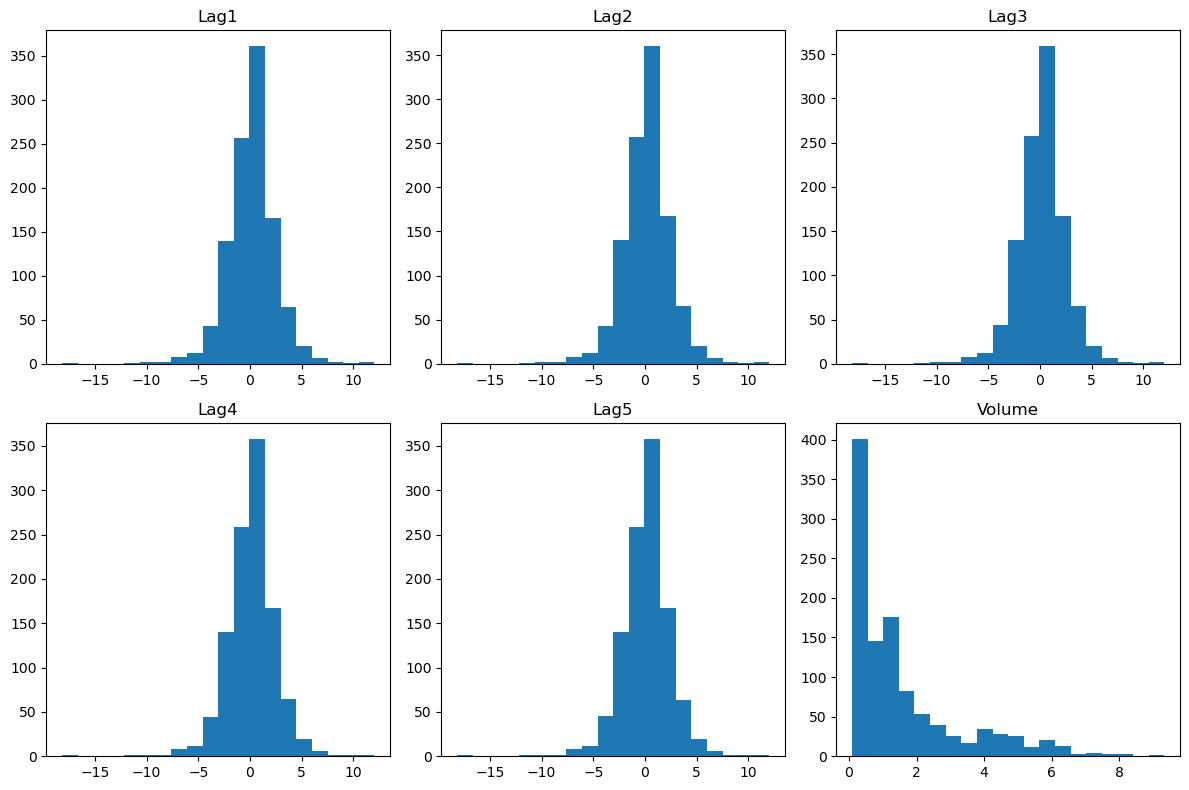

In [5]:
# Histograms of Lag variables and Volume
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, col in zip(axes.flatten(), ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']):
    ax.hist(data[col], bins=20)
    ax.set_title(col)
plt.tight_layout()
plt.show()

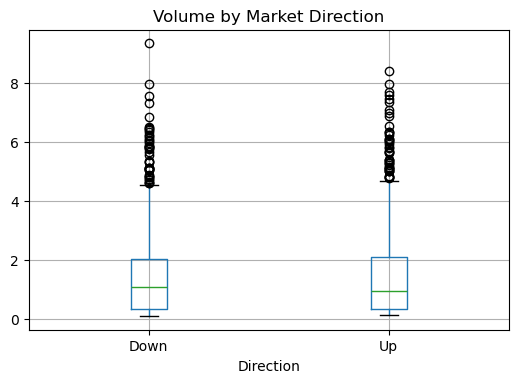

In [6]:
# Boxplot of Volume by Direction
data.boxplot(column='Volume', by='Direction', figsize=(6, 4))
plt.suptitle('')
plt.title('Volume by Market Direction')
plt.show()

**Observations:**
- The lag variables have roughly symmetric distributions centered near zero.
- Volume shows a clear upward trend over time (we will explore below).
- No extreme skewness in the predictors

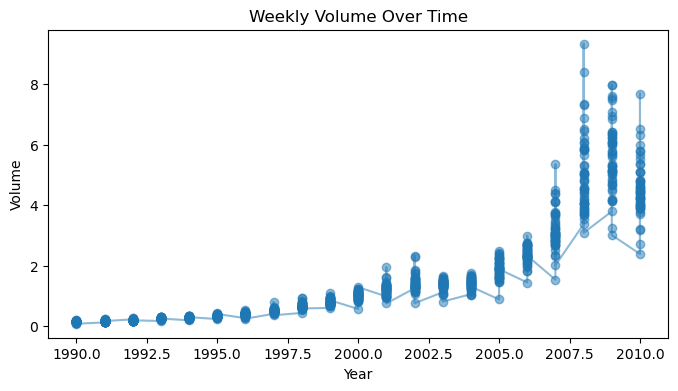

In [7]:
# Time series plot of Volume over years
plt.figure(figsize=(8, 4))
plt.plot(data['Year'], data['Volume'], marker='o', linestyle='-', alpha=0.5)
plt.title('Weekly Volume Over Time')
plt.xlabel('Year')
plt.ylabel('Volume')
plt.show()

Volume has increased steadily over the 21-year period, reflecting growth in trading activity.

3. Logistic Regression on Full Data (Part b)
We fit a logistic regression using `Lag1`–`Lag5` and `Volume` to predict `Direction`.  We'll use `statsmodels.Logit` to obtain p-values.

In [8]:
# Prepare design matrix
y = (data['Direction'] == 'Up').astype(int)
X = data[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']]
X = sm.add_constant(X)

model_full = sm.Logit(y, X).fit(disp=False)
print(model_full.summary())


                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Thu, 03 Jul 2025   Pseudo R-squ.:                0.006580
Time:                        23:23:38   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.0

**Significant Predictors:**  Check the p-values above to see which lag variables (if any) are statistically significant.

## 4. Confusion Matrix & Accuracy (Part c)

Using the fitted model, we classify each week as Up if the predicted probability exceeds 0.5.


In [9]:
probs = model_full.predict(X)
preds = np.where(probs > 0.5, 1, 0)
cm = confusion_matrix(y, preds)
acc = accuracy_score(y, preds)
print("Confusion Matrix:\n", cm)
print(f"Overall Accuracy: {acc:.3f}")

Confusion Matrix:
 [[ 54 430]
 [ 48 557]]
Overall Accuracy: 0.561


*Interpretation:*  The confusion matrix shows true vs.
- False negatives (predict Down when Up)
- False positives (predict Up when Down)

---

## 5. Train/Test Split: 1990–2008 vs. 2009–2010

We split the dataset by year.

In [10]:
train = data[data['Year'] <= 2008]
test = data[data['Year'] > 2008]
y_train = (train['Direction']=='Up').astype(int)
y_test = (test['Direction']=='Up').astype(int)

# Predictor for parts d–h: Lag2 only
X_train_lag2 = sm.add_constant(train[['Lag2']])
X_test_lag2 = sm.add_constant(test[['Lag2']])

# Helper to evaluate and print results
def evaluate_model(name, model, X_t, X_v, y_t, y_v):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    # For classifiers returning probabilities:
    if hasattr(preds, 'dtype') and preds.dtype == float:
        preds = np.where(preds > 0.5, 1, 0)
    cm = confusion_matrix(y_v, preds)
    acc = accuracy_score(y_v, preds)
    print(f"{name}:\nConfusion Matrix:\n{cm}\nAccuracy: {acc:.3f}\n")


### (d) Logistic Regression with Lag2


In [11]:
logit_lag2 = LogisticRegression(solver='liblinear')
evaluate_model('Logistic (Lag2)', logit_lag2, train[['Lag2']], test[['Lag2']], y_train, y_test)


Logistic (Lag2):
Confusion Matrix:
[[ 9 34]
 [ 5 56]]
Accuracy: 0.625



### (e) Linear Discriminant Analysis (Lag2)

lda = LinearDiscriminantAnalysis()
evaluate_model('LDA (Lag2)', lda, train[['Lag2']], test[['Lag2']], y_train, y_test)


### (f) Quadratic Discriminant Analysis (Lag2)

In [12]:
qda = QuadraticDiscriminantAnalysis()
evaluate_model('QDA (Lag2)', qda, train[['Lag2']], test[['Lag2']], y_train, y_test)

QDA (Lag2):
Confusion Matrix:
[[ 0 43]
 [ 0 61]]
Accuracy: 0.587



### (g) K-Nearest Neighbors ($K=1$, Lag2)

In [13]:
knn1 = KNeighborsClassifier(n_neighbors=1)
evaluate_model('KNN (K=1, Lag2)', knn1, train[['Lag2']], test[['Lag2']], y_train, y_test)

KNN (K=1, Lag2):
Confusion Matrix:
[[22 21]
 [30 31]]
Accuracy: 0.510



### (h) Naive Bayes (Lag2)

In [14]:
bayes = GaussianNB()
evaluate_model('Naive Bayes (Lag2)', bayes, train[['Lag2']], test[['Lag2']], y_train, y_test)


Naive Bayes (Lag2):
Confusion Matrix:
[[ 0 43]
 [ 0 61]]
Accuracy: 0.587



## 6. Method Comparison (Part i)
Summarize accuracy for each method on the held-out set.


In [15]:
# Collect results
def get_accuracy(model, X_t, X_v, y_t, y_v):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    if preds.dtype == float:
        preds = np.where(preds>0.5,1,0)
    return accuracy_score(y_v, preds)

results = {
    'Logistic (Lag2)': get_accuracy(LogisticRegression(solver='liblinear'), train[['Lag2']], test[['Lag2']], y_train, y_test),
    'LDA':           get_accuracy(LinearDiscriminantAnalysis(), train[['Lag2']], test[['Lag2']], y_train, y_test),
    'QDA':           get_accuracy(QuadraticDiscriminantAnalysis(), train[['Lag2']], test[['Lag2']], y_train, y_test),
    'KNN (K=1)':     get_accuracy(KNeighborsClassifier(n_neighbors=1), train[['Lag2']], test[['Lag2']], y_train, y_test),
    'Naive Bayes':   get_accuracy(GaussianNB(), train[['Lag2']], test[['Lag2']], y_train, y_test)
}

pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])


,Accuracy
Logistic (Lag2),0.625000
LDA,0.625000
QDA,0.586538
KNN (K=1),0.509615
Naive Bayes,0.586538


The method with the highest accuracy on the test set appears to be the best performer.

## 7. Additional Experiments (Part j)

We can try different combinations of predictors and vary $K$ in K

In [16]:
# Example: KNN with Lag1, Lag2, Volume and K from 1 to 10
scores = []
features = ['Lag1','Lag2','Volume']
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train[features], y_train)
    acc_k = accuracy_score(y_test, knn.predict(test[features]))
    scores.append((k, acc_k))

knn_results = pd.DataFrame(scores, columns=['K','Accuracy']).set_index('K')
knn_results


,Accuracy
K,
1,0.500000
2,0.461538
3,0.480769
4,0.480769
5,0.557692
6,0.519231
7,0.548077
8,0.490385
9,0.576923


From the table above, choose the value of $K$ that maximizes accuracy.

**Feel free to explore**: interactions between lag terms (e.g.
`train['Lag1*Lag2'] = train['Lag1'] * train['Lag2']`), polynomial terms, or adding more lags.